In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
from collections import defaultdict
from datetime import datetime as dt
from bs4 import BeautifulSoup as bs
from IPython.core.display import HTML
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy import stats
import numpy as np
import plotly.express as px
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from filterpy.kalman import KalmanFilter
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta


In [2]:
df = pd.read_csv('batterieData.csv', low_memory = False)
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.drop(df[df['Batt_Li_Voltage'] < 0].index)
# Calcule  limites inférieures et supérieures pour chaque colonne
limites = {}
for col in ['Batt_Li_Voltage', 'Batt_Li_Current']:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    limites[col] = (q1 - 1.5 * iqr, q3 + 1.5 * iqr)

# Filtrer les valeurs aberrantes pour chaque colonne
for col in ['Batt_Li_Voltage', 'Batt_Li_Current']:
    df = df[(df[col] >= limites[col][0]) & (df[col] <= limites[col][1])]

df

,TIMESTAMP,Batt_Li_Voltage,Batt_Li_Current,Batt_Li_Power,Batt_Li_SoC,PV_Voltage,PV_Power,Batt_Li_SetPower_EMS
0,2021-12-31 00:00:00,25.60,-0.058,-1.48,19.85,0.039,0,0.00
1,2021-12-31 00:00:05,25.59,-0.058,-1.48,19.85,0.039,0,0.00
2,2021-12-31 00:00:10,25.60,-0.058,-1.48,19.85,0.040,0,0.00
3,2021-12-31 00:00:15,25.60,-0.059,-1.51,19.85,0.039,0,0.00
4,2021-12-31 00:00:20,25.60,-0.059,-1.51,19.85,0.039,0,0.00
...,...,...,...,...,...,...,...,...
1517991,2022-08-01 23:59:35,27.46,0.185,5.08,94.30,27.420,0.0,0.08
1517992,2022-08-01 23:59:40,27.46,0.185,5.08,94.30,27.410,0.0,0.08
1517993,2022-08-01 23:59:45,27.47,-0.084,-2.31,94.30,27.430,0.0,0.08
1517994,2022-08-01 23:59:50,27.46,0.186,5.11,94.30,27.410,0.0,0.08


In [4]:
df_normalized = df.drop(['TIMESTAMP'],axis=1)
scaler = MinMaxScaler()

df_normalized = pd.DataFrame(scaler.fit_transform(df_normalized))
cols = df.columns[1:]
df_normalized.columns = cols


In [5]:
df_normalized['Batt_Li_Voltage'].describe()

count    814271.000000
mean          0.557458
std           0.214423
min           0.000000
25%           0.398417
50%           0.567282
75%           0.617414
max           1.000000
Name: Batt_Li_Voltage, dtype: float64

In [6]:
df['Batt_Li_Voltage'].describe()

count    814271.000000
mean         26.562767
std           0.812663
min          24.450000
25%          25.960000
50%          26.600000
75%          26.790000
max          28.240000
Name: Batt_Li_Voltage, dtype: float64

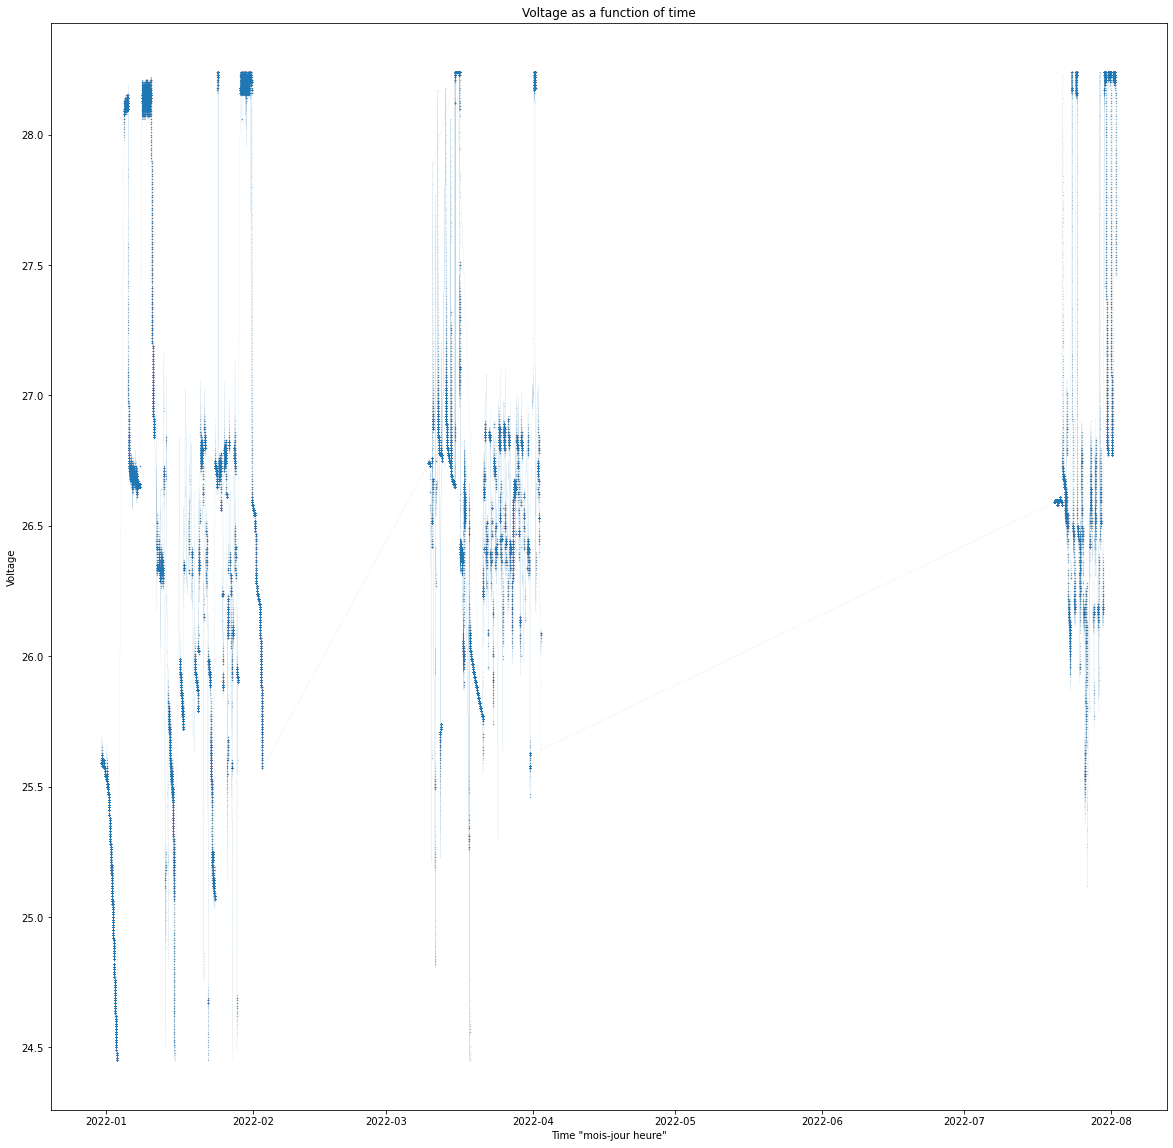

In [6]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df['TIMESTAMP'], df['Batt_Li_Voltage'],linewidth=0.05,marker='.', markersize=0.05)

ax.set_title('Voltage as a function of time')
ax.set_xlabel('Time "mois-jour heure"')
ax.set_ylabel('Voltage')

# Sauvegardez le graphique au format PNG
fig.savefig('Voltage as a function of time')



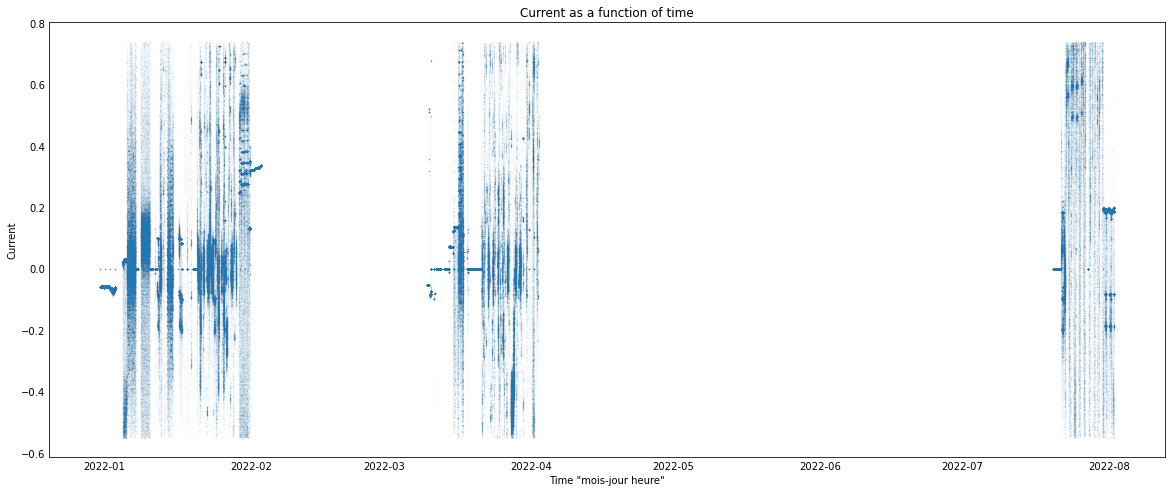

In [10]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df['TIMESTAMP'], df['Batt_Li_Current'],linewidth=0.005,marker='.', markersize=0.05)

ax.set_title('Current as a function of time')
ax.set_xlabel('Time "mois-jour heure"')
ax.set_ylabel('Current')
ax.tick_params(axis='both', which='both', length=0)

Text(0, 0.5, 'SOC %')

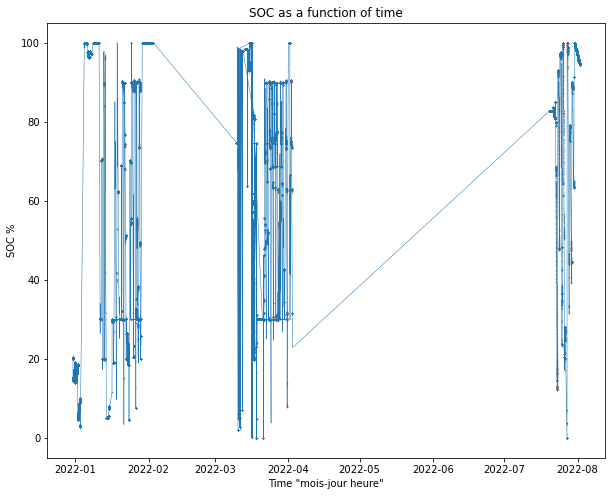

In [35]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df['TIMESTAMP'], df['Batt_Li_SoC'], linewidth=0.5,marker='.', markersize=0.05)

ax.set_title('SOC as a function of time')
ax.set_xlabel('Time "mois-jour heure"')
ax.set_ylabel('SOC %')

Text(0, 0.5, 'PWR_S_Voltage')

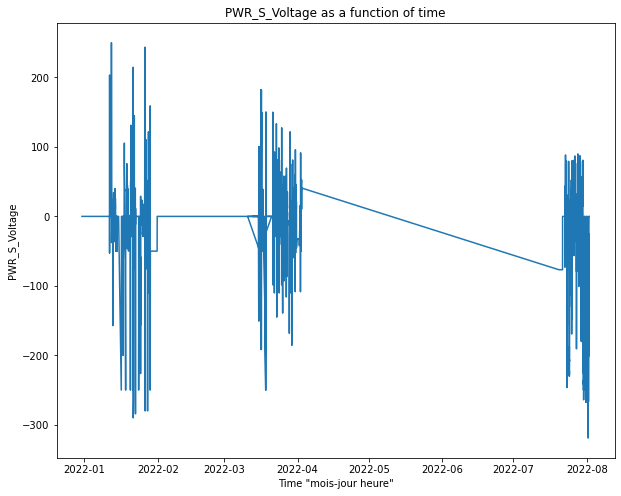

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df['TIMESTAMP'], df['Batt_Li_SetPower_EMS'])

ax.set_title('PWR_S_Voltage as a function of time')
ax.set_xlabel('Time "mois-jour heure"')
ax.set_ylabel('PWR_S_Voltage')

Text(0, 0.5, 'Batt_Li_SetPower_EMS')

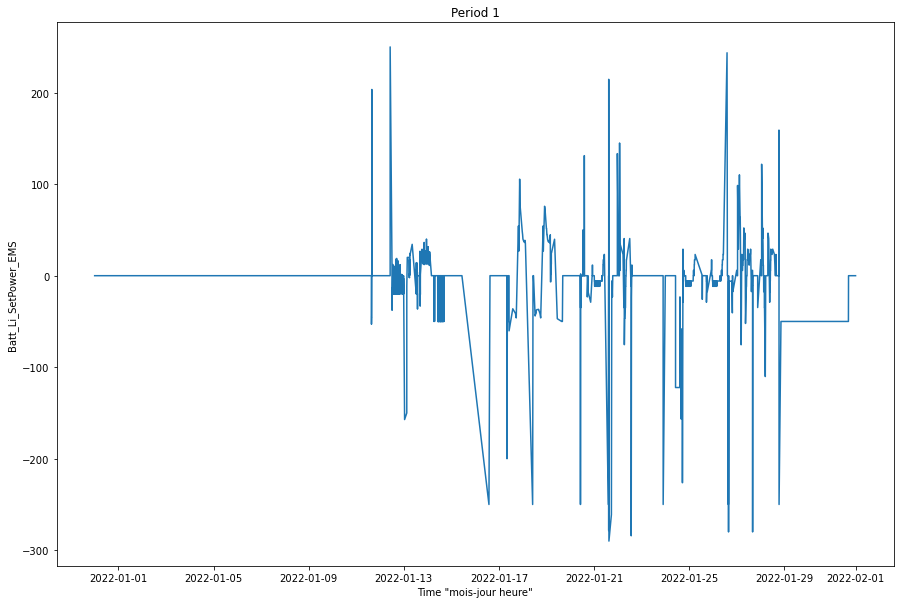

In [33]:
start_date = '2021-12-31 00:00:00'
end_date = '2022-02-01 00:00:00'

df_period = df.loc[(df['TIMESTAMP'] >= start_date) & (df['TIMESTAMP'] <= end_date), ['TIMESTAMP', 'Batt_Li_SetPower_EMS']]
#df_period= df_period.drop(df_period[df_period['Batt_Li_SetPower_EMS'] == 0].index)

fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(df_period['TIMESTAMP'], df_period['Batt_Li_SetPower_EMS'])

ax.set_title('Period 1')
ax.set_xlabel('Time "mois-jour heure"')
ax.set_ylabel('Batt_Li_SetPower_EMS')

In [11]:
# fonction pour déterminer SOC avec la tension 
"""
La fonction donne une estimation de charge instantanée
"""
def calc_soc_tension(tension, tension_nom, soc_nom, a, b, capacite):
    """
    Calcule l'état de charge (SOC) d'une batterie à partir de la tension, de sa valeur nominale,
    de la valeur nominale du SOC, de deux coefficients d'ajustement et de sa capacité.

    Args:
        tension (array-like): Tension en volts.
        tension_nom (float): Tension nominale de la batterie en volts.
        soc_nom (float): Valeur nominale de l'état de charge de la batterie en pourcentage (%).
        a (float): Coefficient d'ajustement pour la tension.
        b (float): Coefficient d'ajustement pour le SOC.
        capacite (float): Capacité de la batterie en ampère-heures.

    Returns:
        array-like: Etat de charge de la batterie en pourcentage (%).
    """
    # Calculer la tension normalisée
    tension_norm = tension / tension_nom
    
    # Calculer l'état de charge normalisé
    soc_norm = (a * tension_norm ** b - 1) / (a - 1)
    
    # Calculer l'état de charge de la batterie en pourcentage (%)
    soc = soc_nom * soc_norm
    
    # Ajuster les valeurs de SOC pour être comprises entre 0% et 100%
    soc = np.clip(soc, 0, 100)
    
    return soc

In [ ]:
ax.plot(df['TIMESTAMP'], calc_soc_tension(df['Batt_Li_SetPower_EMS'], tension_nom, soc_nom, a, b, capacite))

In [12]:
# fonction pour déterminer SOC avec le courant (intégration) -> similaire au coulomb counting
"""
La fonction donne une estimation de charge dans le temps
"""
def calc_soc_courant(courant, temps, capacite):
    """
    Calcule l'état de charge (SOC) d'une batterie à partir du courant et de l'heure.

    Args:
        courant (array-like): Courant en ampères.
        temps (array-like): Temps en secondes.
        capacite (float): Capacité de la batterie en ampère-heures.

    Returns:
        array-like: Etat de charge de la batterie en pourcentage (%).
    """
    # Calculer l'intégrale numérique du courant par rapport au temps
    charge = np.cumsum(courant * (temps[1:] - temps[:-1]))
    
    # Calculer l'état de charge de la batterie en pourcentage (%)
    soc = 100 * charge / capacite
    
    # Ajuster les valeurs de SOC pour être comprises entre 0% et 100%
    soc = np.clip(soc, 0, 100)
    
    return soc

In [24]:
dataframe = df
# Filtre de Kalman
"""Nous apporte une meilleur précision de l'état de charge en combinant les fonctions vues au dessus"""

kf = KalmanFilter(dim_x=1, dim_z=1)
kf.x = np.array([0.1985])  # Etat initial de la batterie (SOC = 50%)
kf.P *= 0.1  # Matrice de covariance de l'état initial
kf.Q = np.diag([0.05**2, 0.1**2, 0.1**2])  # Matrice de covariance du bruit de processus
kf.R = np.diag([0.05**2, 0.1**2, 0.1**2])  # Matrice de covariance du bruit de mesure

# Filtrer les mesures de tension et de courant pour estimer l'état de charge de la batterie
estimated_soc = []
for i in range(len(dataframe)):
    # Convertir les mesures de tension et de courant en état de batterie
    soc_from_voltage = calc_soc_tension(dataframe['Batt_Li_Voltage'][i], 12, 19.85, 0.1, 0.1, 0.145)
    soc_from_current = calc_soc_courant(dataframe['Batt_Li_Current'][i], dataframe['TIMESTAMP'], 0.145)
    soc_measure = (soc_from_voltage + soc_from_current) / 2  # Moyenne des deux mesures
    # Prédiction de l'état de batterie à l'instant i
    kf.predict()
    # Mise à jour de l'état de batterie avec la mesure à l'instant i
    kf.update(soc_measure)
    # Stocker l'estimation de l'état de charge de la batterie à l'instant i
    estimated_soc.append(kf.x[0])


UFuncTypeError: Cannot cast ufunc 'clip' input 0 from dtype('<m8[ns]') to dtype('<m8') with casting rule 'same_kind'

In [30]:
# fonction pour déterminer SOC avec machine learning
"""
La fonction donne une estimation de charge avec une régréssion linéaire
"""
X = df['Batt_Li_Voltage'].values.reshape(-1, 1)
y = df['Batt_Li_SoC'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01)

reg = LinearRegression().fit(X_train, y_train)

score = reg.score(X_test, y_test)
print("test score R2 :", score)

test score R2 : 0.6099323021800226


In [29]:
# fonction pour déterminer SOC avec machine learning
"""
La fonction donne une estimation de charge avec une random forest
"""
X = df['Batt_Li_Voltage'].values.reshape(-1, 1)
y = df['Batt_Li_SoC'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01)

model = RandomForestRegressor()
model.fit(X_train, y_train)

score = model.score(X_test, y_test)
print("test score de la random forest avec le R2 :", score)


test score R2 : 0.8501394101831038


In [11]:
x = df['Batt_Li_Voltage'].values.reshape(-1, 1)
y = df['TIMESTAMP'].values
integrale = 0
y

array(['2021-12-31T00:00:00.000000000', '2021-12-31T00:00:05.000000000',
       '2021-12-31T00:00:10.000000000', ...,
       '2022-08-01T23:59:45.000000000', '2022-08-01T23:59:50.000000000',
       '2022-08-01T23:59:55.000000000'], dtype='datetime64[ns]')

In [12]:
dates = [datetime(2023, 4, 1, 8, 0, 0), 
         datetime(2023, 4, 1, 12, 0, 0), 
         datetime(2023, 4, 2, 8, 0, 0), 
         datetime(2023, 4, 3, 8, 0, 0), 
         datetime(2023, 4, 5, 8, 0, 0)]

# écart de temps minimum de 24 heures
delta = timedelta(hours=24)

# nouvelle liste contenant les dates qui respectent l'écart de temps minimum
new_dates = [dates[0]]  # On ajoute la première date
for date in dates[1:]:
    if date - new_dates[-1] >= delta:
        new_dates.append(date)

print(new_dates)

NameError: name 'datetime' is not defined

In [4]:
x = df['Batt_Li_Voltage'].values.reshape(-1, 1)
y = df['TIMESTAMP'].values
ValeureIni = 0
integrale = [ValeureIni]

first_date = datetime.utcfromtimestamp(y[0].astype('O')/1e9)

new_dates = [(datetime.utcfromtimestamp(date.astype('O')/1e9) - first_date).total_seconds() for date in y]
long = len(new_dates)-1
long

814270

In [5]:
for i in range(long):
    aire = (new_dates[i+1]-new_dates[i])*x[i]
    integrale = np.append(integrale, aire)

In [6]:
len(integrale)

814271

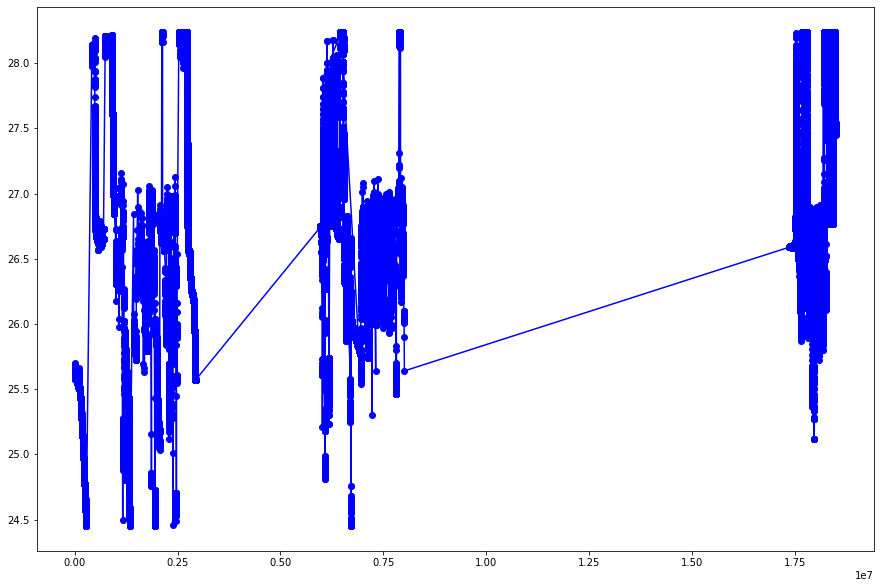

In [7]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(new_dates,x,"bo-")

In [38]:
squares = np.array([])

for i in range(5):
    square = i ** 2
    squares = np.append(squares, square)

print(squares)

[ 0.  1.  4.  9. 16.]
